In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, classification_report, mean_squared_error, r2_score

# --- Configuration ---
RANDOM_STATE = 42
TEST_SIZE = 0.2

In [8]:
# --- Phase 1: Advanced Data Preparation ---
print("--- Starting Task 4: Predictive Modeling ---")
print("\n--- Phase 1: Advanced Data Preparation ---")

# Load data, addressing the dtype warning from Task 3
df = pd.read_csv("./../data/MachineLearningRating_v3.txt", sep = "|")
print(f"Data loaded. Shape: {df.shape}")

# 1. Feature Engineering
# Using 2015 as the reference year since data is from 2014-2015
df['VehicleAge'] = 2015 - df['RegistrationYear']

# 2. Target Engineering
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)
# Log-transform the target for the severity model to handle skewness
df['LogTotalClaims'] = np.log1p(df['TotalClaims'])

# 3. Feature Selection
# Separate features by type and cardinality
numerical_features = ['VehicleAge', 'cubiccapacity', 'kilowatts', 'CustomValueEstimate']
low_card_cat_features = ['Province', 'Gender', 'MaritalStatus', 'bodytype']
high_card_cat_features = ['PostalCode', 'make'] # Example high-cardinality features

features = numerical_features + low_card_cat_features + high_card_cat_features
X = df[features]
y_class = df['HasClaim']
y_reg = df['LogTotalClaims']

# 4. Impute Missing Values
# Numerical
num_imputer = SimpleImputer(strategy='median')
X[numerical_features] = num_imputer.fit_transform(X[numerical_features])

# Categorical
cat_imputer = SimpleImputer(strategy='most_frequent')
X[low_card_cat_features + high_card_cat_features] = cat_imputer.fit_transform(X[low_card_cat_features + high_card_cat_features])
print("Missing values imputed.")

# 5. Categorical Feature Encoding
# One-Hot Encode low-cardinality features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_ohe = pd.DataFrame(encoder.fit_transform(X[low_card_cat_features]), columns=encoder.get_feature_names_out(), index=X.index)

# Target Encode high-cardinality features
# NOTE: In a production pipeline, to prevent data leakage, this encoding should be learned
# on the training data ONLY and then applied to the test set.
# For simplicity in this script, we learn it from the full dataset.
for col in high_card_cat_features:
    target_mean = df.groupby(col)['HasClaim'].mean()
    X[f'{col}_target_encoded'] = X[col].map(target_mean)

# Combine all features into a final dataframe
X_processed = pd.concat([X[numerical_features + [f'{col}_target_encoded' for col in high_card_cat_features]], X_ohe], axis=1)
print(f"Feature processing complete. Final feature shape: {X_processed.shape}")

# 6. Train-Test Split
X_train, X_test, y_train_class, y_test_class, y_train_reg, y_test_reg = train_test_split(
    X_processed, y_class, y_reg, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_class
)
print("Data split into 80% training and 20% testing sets.")


--- Starting Task 4: Predictive Modeling ---

--- Phase 1: Advanced Data Preparation ---


/tmp/ipykernel_21396/463983841.py:6: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./../data/MachineLearningRating_v3.txt", sep = "|")


Data loaded. Shape: (1000098, 52)


/home/shivers/dev/github.com/AbenezerWork/end-to-end-Insurance-Risk-Analytics-and-Predictive-Modelling/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_21396/463983841.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_features] = num_imputer.fit_transform(X[numerical_features])
/tmp/ipykernel_21396/463983841.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

Missing values imputed.


/tmp/ipykernel_21396/463983841.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'{col}_target_encoded'] = X[col].map(target_mean)
/tmp/ipykernel_21396/463983841.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'{col}_target_encoded'] = X[col].map(target_mean)


Feature processing complete. Final feature shape: (1000098, 34)
Data split into 80% training and 20% testing sets.


In [11]:
# --- Phase 2: Model Building & Evaluation ---
print("\n--- Phase 2: Model Building & Evaluation ---")

# Lists to store results for final comparison
classification_results = []
regression_results = []

# --- Part A: Claim Probability Model (Classification) ---
print("\n--- Part A: Claim Probability Model (Classification) ---")
scale_pos_weight = (y_train_class == 0).sum() / (y_train_class == 1).sum()

models_class = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
}

for name, model in models_class.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train_class)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred_class = (y_pred_proba > 0.5).astype(int)
    
    auc = roc_auc_score(y_test_class, y_pred_proba)
    report = classification_report(y_test_class, y_pred_class, output_dict=True)
    
    classification_results.append({
        "Model": name,
        "AUC Score": auc,
        "Precision (Claim=1)": report['1']['precision'],
        "Recall (Claim=1)": report['1']['recall'],
        "F1-Score (Claim=1)": report['1']['f1-score']
    })
    print(f"Evaluation for {name} complete.")


# --- Part B: Claim Severity Model (Regression) ---
print("\n--- Part B: Claim Severity Model (Regression) ---")
X_train_sev = X_train[y_train_class == 1]
y_train_sev = y_train_reg[y_train_class == 1]
X_test_sev = X_test[y_test_class == 1]
y_test_sev = y_test_reg[y_test_class == 1]
y_test_sev_orig = np.expm1(y_test_sev)

models_reg = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=RANDOM_STATE),
    'XGBoost': xgb.XGBRegressor(random_state=RANDOM_STATE, objective='reg:squarederror')
}

for name, model in models_reg.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_sev, y_train_sev)
    y_pred_sev_log = model.predict(X_test_sev)
    y_pred_sev_orig = np.expm1(y_pred_sev_log)
    
    rmse = np.sqrt(mean_squared_error(y_test_sev_orig, y_pred_sev_orig))
    r2 = r2_score(y_test_sev_orig, y_pred_sev_orig)
    
    regression_results.append({
        "Model": name,
        "RMSE (Rand)": rmse,
        "R-squared (R²)": r2
    })
    print(f"Evaluation for {name} complete.")



--- Phase 2: Model Building & Evaluation ---

--- Part A: Claim Probability Model (Classification) ---

Training Logistic Regression...


/home/shivers/dev/github.com/AbenezerWork/end-to-end-Insurance-Risk-Analytics-and-Predictive-Modelling/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/shivers/dev/github.com/AbenezerWork/end-to-end-Insurance-Risk-Analytics-and-Predictive-Modelling/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/shivers/dev/github.com/AbenezerWork/end-to-end-Insurance-Risk-Analytics-and-Predictive-Modelling/.venv/lib/python3.13/site-packages/sklearn/metrics/_classif

Evaluation for Logistic Regression complete.

Training Random Forest...
Evaluation for Random Forest complete.

Training XGBoost...


/home/shivers/dev/github.com/AbenezerWork/end-to-end-Insurance-Risk-Analytics-and-Predictive-Modelling/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:39:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Evaluation for XGBoost complete.

--- Part B: Claim Severity Model (Regression) ---

Training Linear Regression...
Evaluation for Linear Regression complete.

Training Random Forest...
Evaluation for Random Forest complete.

Training XGBoost...
Evaluation for XGBoost complete.



--- Phase 3: Model Interpretability with SHAP ---
Generating feature importance plots for the winning model (XGBoost).


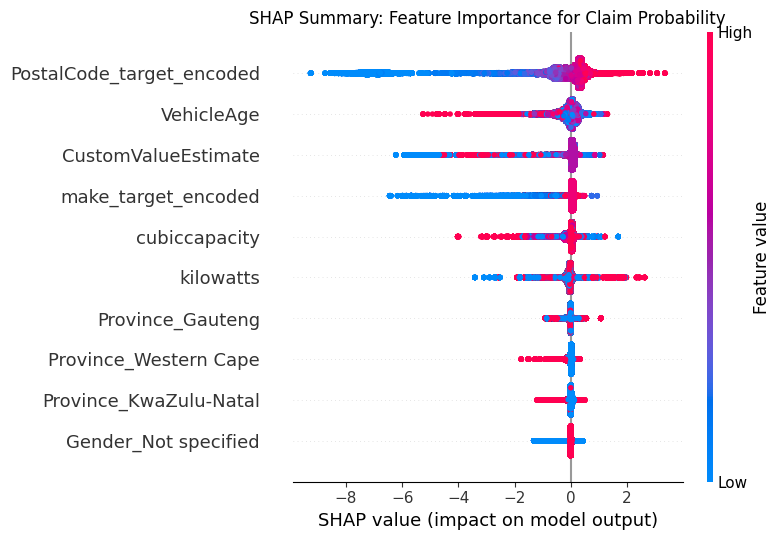

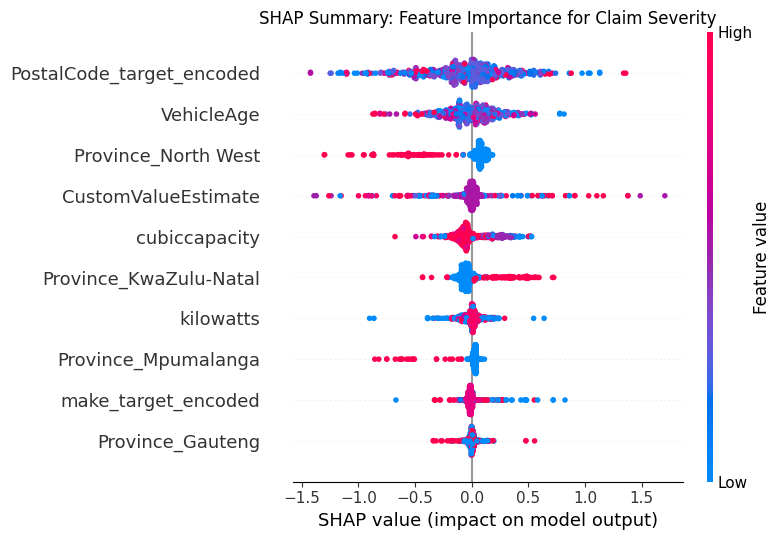

In [12]:
# --- Phase 3: Model Interpretability with SHAP and Matplotlib ---
print("\n--- Phase 3: Model Interpretability with SHAP ---")
print("Generating feature importance plots for the winning model (XGBoost).")

# SHAP for Classification Model
xgb_class_model = models_class['XGBoost']
explainer_class = shap.TreeExplainer(xgb_class_model)
shap_values_class = explainer_class.shap_values(X_test)
plt.figure()
plt.title("SHAP Summary: Feature Importance for Claim Probability")
shap.summary_plot(shap_values_class, X_test, max_display=10, show=True)

# SHAP for Severity Model
xgb_reg_model = models_reg['XGBoost']
explainer_sev = shap.TreeExplainer(xgb_reg_model)
shap_values_sev = explainer_sev.shap_values(X_test_sev)
plt.figure()
plt.title("SHAP Summary: Feature Importance for Claim Severity")
shap.summary_plot(shap_values_sev, X_test_sev, max_display=10, show=True)


In [13]:
# --- Phase 4: Generate Performance Summary ---
print("\n--- Phase 4: Final Model Performance Comparison ---")

# Classification Results Table
class_df = pd.DataFrame(classification_results).set_index('Model')
print("\n--- Classification Model Performance ---")
print(class_df.round(4))

# Regression Results Table
reg_df = pd.DataFrame(regression_results).set_index('Model')
print("\n--- Regression Model Performance ---")
print(reg_df.round(4))



--- Phase 4: Final Model Performance Comparison ---

--- Classification Model Performance ---
                     AUC Score  Precision (Claim=1)  Recall (Claim=1)  \
Model                                                                   
Logistic Regression     0.5216               0.0000            0.0000   
Random Forest           0.6138               0.0046            0.3835   
XGBoost                 0.6666               0.0045            0.5932   

                     F1-Score (Claim=1)  
Model                                    
Logistic Regression              0.0000  
Random Forest                    0.0091  
XGBoost                          0.0090  

--- Regression Model Performance ---
                   RMSE (Rand)  R-squared (R²)
Model                                         
Linear Regression   43620.8455         -0.1270
Random Forest       43567.3722         -0.1242
XGBoost             44527.3267         -0.1743
